#### Set up ####

In [213]:
from dask_cloudprovider.aws import EC2Cluster 
from dask.distributed import Client
import configparser
import os
import contextlib
import re
import dask
from platform import python_version
import matplotlib.pyplot as plt
import dask.dataframe as dd
import dask.array as da
from dask_ml.linear_model import LinearRegression
import pandas as pd
import numpy as np

def get_aws_credentials():
    """Read in your AWS credentials file and convert to environment variables."""
    parser = configparser.RawConfigParser()
    
    parser.read(os.path.expanduser('~/.aws/config'))
    config = parser.items('default')
    
    parser.read(os.path.expanduser('~/.aws/credentials'))
    credentials = parser.items('default')
    
    all_credentials = {key.upper(): value for key, value in [*config, *credentials]}
    with contextlib.suppress(KeyError):
        all_credentials["AWS_REGION"] = all_credentials.pop("REGION")
        
    return all_credentials

# Pass in AWS Credentials + any extra packages you would like to install on cluster via `pip`
env_vars = get_aws_credentials()
#env_vars["EXTRA_PIP_PACKAGES"] = "s3fs"
env_vars["EXTRA_PIP_PACKAGES"] = "s3fs pandas==1.5.3 pyarrow==11.0.0 cloudpickle==2.2.1 dask_ml"

# Select software installed on scheduler + worker instances based on client Python + Dask versions
# versions need to match across client, scheduler, worker -- slight mismatches are OK, though
py_v = '-py' + re.findall(r'\d{1}.\d+', python_version())[0]
#dask_docker_tag = f"daskdev/dask:{dask.__version__ + py_v}"
dask_docker_tag = "daskdev/dask:2023.6.0-py3.10"
print('Docker Image: ', dask_docker_tag)

# launch a cluster of 5 r5.large instances (10 vCPUs):
# 1 scheduler
# 4 workers (2 threads + 16 GB RAM each)
cluster = EC2Cluster(instance_type='r5.large',
                     n_workers=8,
                     security=False,
                     docker_image=dask_docker_tag,
                     env_vars=env_vars
)

Docker Image:  daskdev/dask:2023.6.0-py3.10
Creating scheduler instance
Created instance i-099143386c7d40630 as dask-21476fa2-scheduler
Waiting for scheduler to run at 44.211.134.54:8786
Scheduler is running
Creating worker instance


/usr/lib/python3.10/contextlib.py:142: UserWarning: Creating your cluster is taking a surprisingly long time. This is likely due to pending resources. Hang tight! 
  next(self.gen)


Creating worker instance
Creating worker instance
Creating worker instance
Creating worker instance
Creating worker instance
Creating worker instance
Creating worker instance
Created instance i-016efe3c56f4c5f4d as dask-21476fa2-worker-087cf460
Created instance i-0d3306cb951a02801 as dask-21476fa2-worker-e320f69a
Created instance i-06b15df3c465cf4fd as dask-21476fa2-worker-9e1ab4d1
Created instance i-09dd6dc164056cd2b as dask-21476fa2-worker-50162dad
Created instance i-04b7175c8ad906f97 as dask-21476fa2-worker-e68e6c2d
Created instance i-0bac5a640510734c3 as dask-21476fa2-worker-4abc5ae2
Created instance i-055fb6c32ed48d11a as dask-21476fa2-worker-388fc901
Created instance i-0d440b777d810cf8b as dask-21476fa2-worker-697d988a


In [214]:
client = Client(cluster)
client

/home/rjrivarola/.local/lib/python3.10/site-packages/distributed/client.py:1395: VersionMismatchWarning: Mismatched versions found

+---------+-----------------+-----------------+-----------------+
| Package | Client          | Scheduler       | Workers         |
+---------+-----------------+-----------------+-----------------+
| lz4     | 3.1.3+dfsg      | 4.3.2           | 4.3.2           |
| msgpack | 1.1.0           | 1.0.5           | 1.0.5           |
| numpy   | 1.26.4          | 1.24.3          | 1.24.3          |
| python  | 3.10.12.final.0 | 3.10.10.final.0 | 3.10.10.final.0 |
| toolz   | 1.0.0           | 0.12.0          | 0.12.0          |
| tornado | 6.4             | 6.3.2           | 6.3.2           |
+---------+-----------------+-----------------+-----------------+
  


UndefinedError: 'n_workers' is undefined

<Client: 'tcp://172.31.83.37:8786' processes=8 threads=16, memory=122.61 GiB>

#### Load data and summary statistics

In [215]:
qn = dd.read_csv("s3://final-project-rrivarola/qn_data.csv",
                 storage_options={
                     "key": env_vars["AWS_ACCESS_KEY_ID"],
                     "secret": env_vars["AWS_SECRET_ACCESS_KEY"],
                     "token": env_vars.get("AWS_SESSION_TOKEN"),
                     },
                 dtype={
                     'value': 'float64',
                     'qapac': 'float64',
                     'height': 'float64',
                     'rivers': 'float64',
                     'slope': 'float64',
                     'valley': 'float64',
                     'ID': 'float64',
                     'prox': 'float64',
                     'reg1max': 'float64',
                     'ecomax': 'float64',
                 })
# Im not sure why but sometimes I would get credential issues when loading the data. Passing the credentials directly solved this

The loaded data comes from 16 routes from the QÑ. These routes were especifically chosen because they connected key locations for the Incas: densely populated centers and religious centers. To generate the grids, we used 10km buffers for each route and then divided that area using 50m by 50m cells.

The definition of the relevant variables in the dataset is the following:
- qapac (binary): equals 1 if the cell is 300m or less from the QÑ
- height (continuous): height of the cell (in meters)
- slope (continuous): slope of the cell (in degrees)
- rivers (binary): equals 1 if the cell is at 100m or less from a river
- valley (binary): equals 1 if the cell is at 100m or less from a valley (rich agricultural land)
- ID (categorical): route ID
- prox (continuous): distance to the closest QÑ point

In [ ]:
# Some basic data cleaning (just dropping missing values)
print(qn.head())
print(len(qn))
drop_nas = ['height', 'slope', 'rivers', 'valley', 'prox', 'qapac'] # drop rows with missing values in relevant variables
vars = ['height', 'slope', 'rivers', 'valley'] # independent variables
qn = qn.dropna(subset=drop_nas)
print(len(qn))

   fid  value  qapac     height  rivers      slope  valley   ID       prox  \
0    1    1.0    0.0  487.91833     0.0  11.028760     0.0  1.0  6147.0645   
1    2    1.0    0.0  474.71585     0.0   9.835068     0.0  1.0  6128.9346   
2    3    1.0    0.0  457.08777     0.0   7.394261     0.0  1.0  6112.3877   
3    4    1.0    0.0  445.67984     0.0   7.007072     0.0  1.0  6097.4355   
4    5    1.0    0.0  434.65704     0.0   7.528602     0.0  1.0  6084.0903   

   reg1max  ecomax  
0      3.0     0.0  
1      3.0     0.0  
2      3.0     0.0  
3      3.0     0.0  
4      3.0     0.0  
11652279
11300332


As we can see, the data has more than 400k cells where the QN goes through, which represents around 4% of the dataset.

The ID variable tells us the specific route. We can tell that there are important differences in the number of cells by route. This is normal, as some routes are larger than others.

In [229]:
qapac_counts = qn['qapac'].value_counts().compute()
ID_counts = qn['ID'].value_counts().compute()
print(qapac_counts)
print(ID_counts)

0.0    10856939
1.0      443393
Name: qapac, dtype: int64
1.0     1472620
9.0      979303
7.0      977338
3.0      966814
14.0     926036
5.0      830383
4.0      778384
13.0     767332
16.0     663796
12.0     632911
8.0      627043
11.0     577245
10.0     507463
6.0      398454
2.0      125023
15.0      70187
Name: ID, dtype: int64


As expected, cells where the QÑ goes through (qapac equals 1) have lower height and slope, and are closer to rivers and valleys, both in terms of mean and median values. This makes sense, while the logic behind the design of QÑ roads is not known, it is expected that they preferred less high places, with less pronounced slopes, and closer to valleys and rivers (sources of food and other resources).  

In [230]:
grouped = qn[vars + ['qapac']].groupby('qapac')

stats_mean = grouped.mean().compute()
stats_median = grouped.median().compute()
print(stats_mean)
print(stats_median)

            height      slope    rivers    valley
qapac                                            
0.0    2581.143056  13.470134  0.038754  0.267026
1.0    2367.090858   9.176803  0.119140  0.432118
          height      slope  rivers  valley
qapac                                      
0.0    3289.3723  11.944684     0.0     0.0
1.0    3154.5330   5.961256     0.0     0.0


Before using these variables for regression analysis, we will standardize them to facilitate interpretation

In [217]:
# means and stds
means = qn[vars].mean().compute()
stds = qn[vars].std().compute()

# Standardize each var (I ended up using this approach because I kept getting index errors)
def standardize_partition(df):
    df_std = (df[vars] - means) / stds
    df_std.columns = [f"{col}_std" for col in df_std.columns]
    return df_std

standardized = qn.map_partitions(
    lambda df: standardize_partition(df).set_index(df.index)
)
qn_std = dd.concat([qn, standardized], axis=1)

/home/rjrivarola/.local/lib/python3.10/site-packages/dask/dataframe/multi.py:1291: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indices of each dataframes are 
 aligned. This assumption is not generally safe.
  warnings.warn(


In [231]:
# Check if join worked properly: as valley is binary, the mean standardized values should equal the only two standardized values
print(qn_std.groupby('valley')['valley_std'].mean().compute())
print(qn_std.head())

valley
0.0   -0.613571
1.0    1.629802
Name: valley_std, dtype: float64
   fid  value  qapac     height  rivers      slope  valley   ID       prox  \
0    1    1.0    0.0  487.91833     0.0  11.028760     0.0  1.0  6147.0645   
1    2    1.0    0.0  474.71585     0.0   9.835068     0.0  1.0  6128.9346   
2    3    1.0    0.0  457.08777     0.0   7.394261     0.0  1.0  6112.3877   
3    4    1.0    0.0  445.67984     0.0   7.007072     0.0  1.0  6097.4355   
4    5    1.0    0.0  434.65704     0.0   7.528602     0.0  1.0  6084.0903   

   reg1max  ecomax  height_std  slope_std  rivers_std  valley_std  
0      3.0     0.0   -1.248076  -0.219992   -0.209143   -0.613571  
1      3.0     0.0   -1.255979  -0.335528   -0.209143   -0.613571  
2      3.0     0.0   -1.266532  -0.571770   -0.209143   -0.613571  
3      3.0     0.0   -1.273361  -0.609245   -0.209143   -0.613571  
4      3.0     0.0   -1.279960  -0.558767   -0.209143   -0.613571  


### Regression model

First we will fit a linear regression model. By comparing the coefficients, we can get a sense of the relative importante of each of these variables as determinants of the QÑ route. We will run a set of regressions using the 'prox' variable to filter our dataset.

First, we will run models pooling all the routes together (including route dummies). Second, we will run each regression for each route.

**Pooled routes**

In [221]:
# Create route dummy variables
qn_std = qn_std.categorize(columns=['ID'])
ID_dummies = dd.get_dummies(qn_std['ID'], prefix='ID', dtype=np.float32).persist()
qn_std_dummies = dd.concat([qn_std, ID_dummies], axis=1).persist()
dummies_vars = list(ID_dummies.columns)

vars_std = ['height_std', 'slope_std', 'rivers_std', 'valley_std']
buffers = list(range(1000, 10001, 1000))
results = {}

for buffer in buffers:
    # Filter for prox <= threshold
    sub = qn_std_dummies[qn_std_dummies['prox'] <= buffer]
    sub = sub.persist()

    # Convert to Dask arrays
    X = sub[vars_std + dummies_vars].to_dask_array(lengths=True)
    y = sub['qapac'].to_dask_array(lengths=True)

    # Fit model
    model = LinearRegression(fit_intercept=False)
    model.fit(X, y)

    # Get coefficients
    coefs = model.coef_[:len(vars_std)]
    squared = coefs**2
    normalized = squared / squared.sum()

    results[buffer] = normalized
    print(f"LinearRegression with {buffer} buffer done")

/home/rjrivarola/.local/lib/python3.10/site-packages/dask/dataframe/multi.py:1291: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indices of each dataframes are 
 aligned. This assumption is not generally safe.
  warnings.warn(


LinearRegression with 1000 buffer done
LinearRegression with 2000 buffer done
LinearRegression with 3000 buffer done
LinearRegression with 4000 buffer done
LinearRegression with 5000 buffer done
LinearRegression with 6000 buffer done
LinearRegression with 7000 buffer done
LinearRegression with 8000 buffer done
LinearRegression with 9000 buffer done
LinearRegression with 10000 buffer done


In [222]:
coeffs = pd.DataFrame(results, index=vars_std).T
coeffs.index.name = 'buffer'
coeffs

,height_std,slope_std,rivers_std,valley_std
buffer,,,,
1000,0.002009,0.856985,0.138008,0.002998
2000,0.007157,0.686721,0.278331,0.027792
3000,0.031318,0.574793,0.334830,0.059059
4000,0.053096,0.502927,0.358797,0.085181
5000,0.067704,0.468052,0.364393,0.099852
6000,0.081741,0.456088,0.352682,0.109489
7000,0.094803,0.452186,0.327696,0.125315
8000,0.102204,0.448479,0.304661,0.144655
9000,0.108875,0.438797,0.294901,0.157428


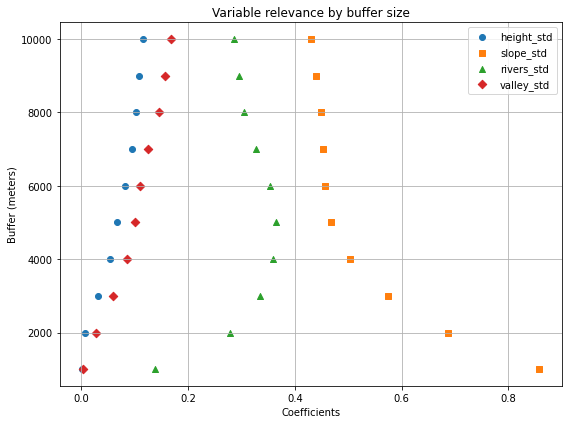

In [227]:
import matplotlib.pyplot as plt

coeffs_plot = coeffs.reset_index().rename(columns={'index': 'buffer'})

# Plot setup
plt.figure(figsize=(8, 6))
markers = ['o', 's', '^', 'D']  # different markers for each variable

for i, var in enumerate(vars_std):
    plt.scatter(coeffs_plot[var], coeffs_plot['buffer'], label=var, marker=markers[i])

plt.xlabel("Coefficients")
plt.ylabel("Buffer (meters)")
plt.title("Variable relevance by buffer size")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("coeffs_pooled.png", dpi=300)
plt.show()


**Models by route**

When running these models, I started getting errors because some partitions become empty after the filtering. After many attemps, I found gathering data in just one partition (repartition(npartitions=1)) and then re-distributing it solved this issue.

In [219]:
import gc
from dask.distributed import wait
#vars_std = ['height_std', 'slope_std', 'rivers_std', 'valley_std']
buffers = list(range(1000, 10001, 1000))
results_route = []

for route in range(1, 17):
    for buffer in buffers:
        # Filter for prox <= threshold
        sub = qn_std[(qn_std['ID'] == route) & (qn_std['prox'] <= buffer)]
        sub = sub.persist()

        # Manage case when partitions become empty after filtering
        partition_counts = sub.map_partitions(len).compute()
        if (partition_counts == 0).any():
            sub = sub.reset_index(drop=True)
            sub = sub.repartition(npartitions=1) # gather data in one partition
            sub = sub.repartition(npartitions=16) # distribute again

        # Convert to Dask arrays
        X = sub[vars_std].to_dask_array(lengths=True)
        y = sub['qapac'].to_dask_array(lengths=True)

        # Fit model
        model = LinearRegression(fit_intercept=False)
        model.fit(X, y)

        # Get coefficients
        coefs = model.coef_

        # Square and normalize
        squared = coefs**2
        normalized = squared / squared.sum()

        results_route.append({
            'ID': route,
            'buffer': buffer,
            **{var: val for var, val in zip(vars_std, normalized)}
        })

        # drop .persist()
        wait(sub)
        del sub
        gc.collect()

        print(f"LinearRegression for route {route} and buffer {buffer} done")

Task exception was never retrieved
future: <Task finished name='Task-146470' coro=<Client._gather.<locals>.wait() done, defined at /home/rjrivarola/.local/lib/python3.10/site-packages/distributed/client.py:2196> exception=AllExit()>
Traceback (most recent call last):
  File "/home/rjrivarola/.local/lib/python3.10/site-packages/distributed/client.py", line 2205, in wait
    key : str, list
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-146471' coro=<Client._gather.<locals>.wait() done, defined at /home/rjrivarola/.local/lib/python3.10/site-packages/distributed/client.py:2196> exception=AllExit()>
Traceback (most recent call last):
  File "/home/rjrivarola/.local/lib/python3.10/site-packages/distributed/client.py", line 2205, in wait
    key : str, list
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-146472' coro=<Client._gather.<locals>.wait() done, defined at /home/rjrivarola/.local/lib/pyt

LinearRegression for route 1 and buffer 1000 done
LinearRegression for route 1 and buffer 2000 done
LinearRegression for route 1 and buffer 3000 done
LinearRegression for route 1 and buffer 4000 done
LinearRegression for route 1 and buffer 5000 done
LinearRegression for route 1 and buffer 6000 done
LinearRegression for route 1 and buffer 7000 done
LinearRegression for route 1 and buffer 8000 done
LinearRegression for route 1 and buffer 9000 done
LinearRegression for route 1 and buffer 10000 done
LinearRegression for route 2 and buffer 1000 done
LinearRegression for route 2 and buffer 2000 done
LinearRegression for route 2 and buffer 3000 done
LinearRegression for route 2 and buffer 4000 done
LinearRegression for route 2 and buffer 5000 done
LinearRegression for route 2 and buffer 6000 done
LinearRegression for route 2 and buffer 7000 done
LinearRegression for route 2 and buffer 8000 done
LinearRegression for route 2 and buffer 9000 done
LinearRegression for route 2 and buffer 10000 don

In [220]:
coeffs_route = pd.DataFrame(results_route)
coeffs_route

,ID,buffer,height_std,slope_std,rivers_std,valley_std
0,1,1000,0.184591,0.764747,0.002612,0.048050
1,1,2000,0.184488,0.726060,0.006242,0.083211
2,1,3000,0.210317,0.641529,0.007920,0.140233
3,1,4000,0.225599,0.581798,0.010709,0.181895
4,1,5000,0.243920,0.524799,0.011357,0.219925
...,...,...,...,...,...,...
155,16,6000,0.023812,0.605566,0.037566,0.333056
156,16,7000,0.013057,0.574027,0.057218,0.355697
157,16,8000,0.005840,0.554322,0.049315,0.390524
158,16,9000,0.003398,0.537920,0.047308,0.411374


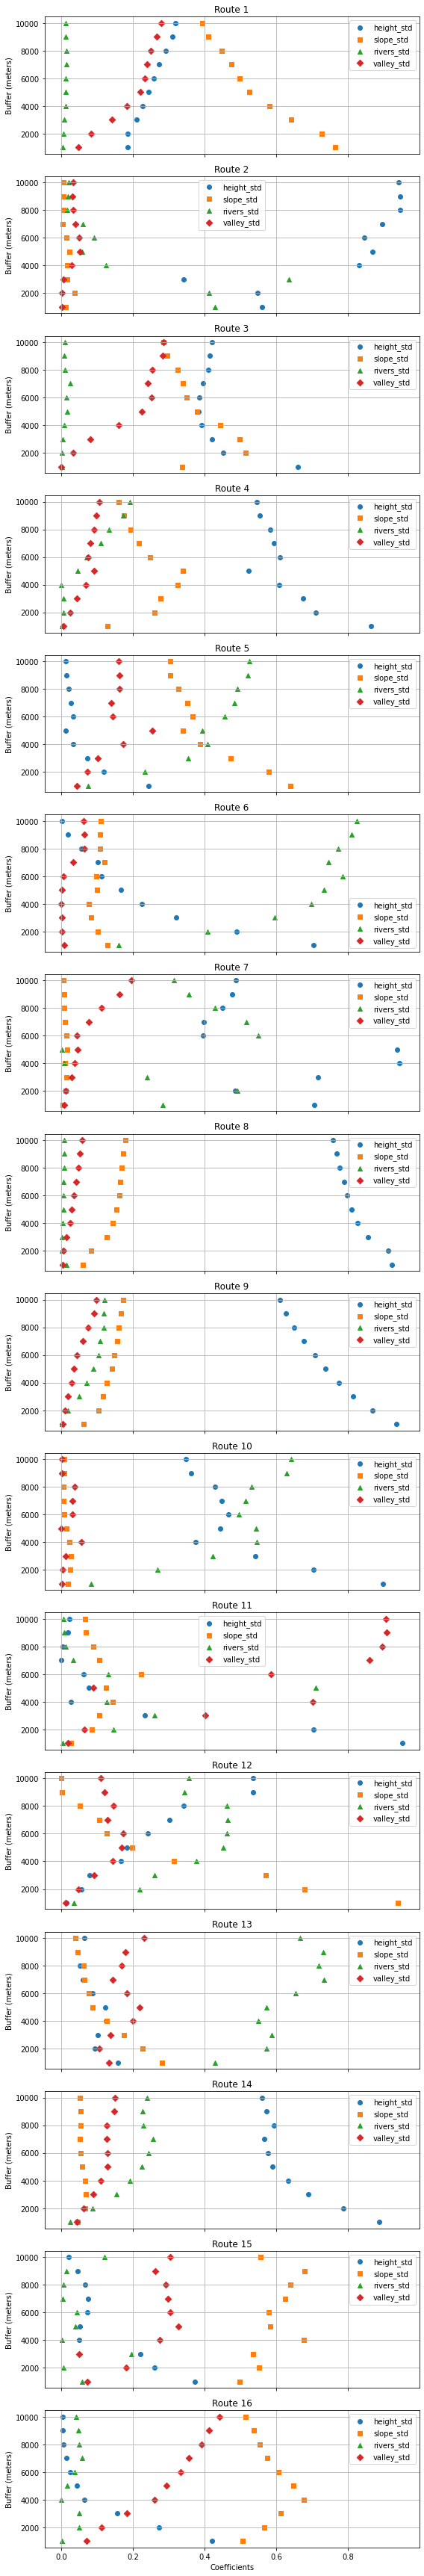

In [228]:
unique_ids = coeffs_route['ID'].unique()

# Create subplots
fig, axes = plt.subplots(nrows=len(unique_ids), ncols=1, figsize=(8, 3 * len(unique_ids)), sharex=True)

for ax, route_id in zip(axes, unique_ids):
    df = coeffs_route[coeffs_route['ID'] == route_id]

    for var, marker in zip(vars_std, markers):
        ax.scatter(df[var], df['buffer'], label=var, marker=marker)

    ax.set_title(f"Route {route_id}")
    ax.set_ylabel("Buffer (meters)")
    ax.grid(True)
    ax.legend()

plt.xlabel("Coefficients")
plt.tight_layout()
plt.savefig("coeffs_routes.png", dpi=300, bbox_inches='tight')
plt.show()


In [212]:
cluster.close()

Terminated dask-cd536498-worker-bb153e52 (i-032b15160fc182e79)
Terminated dask-cd536498-worker-67403d22 (i-06469069aa9219dfa)
Terminated dask-cd536498-worker-6138b4a4 (i-09821417cadb49396)
Terminated dask-cd536498-worker-9cf4ac4d (i-08696cc6db13d19d7)
Terminated dask-cd536498-scheduler (i-0d7351f1c5b9a3ba9)
